In [162]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [163]:
data=pd.read_csv("Regression_data.csv")

In [164]:
data.columns

Index(['Date ', 'High_Stationary', 'HIGH ', 'lag_1', 'lag_2'], dtype='object')

# Train Test Split

In [165]:
def tts(data):
    data = data.drop(['HIGH ','Date '],axis=1)
    train, test = data[0:-12].values, data[-12:].values
    
    return train, test

train, test = tts(data)

In [166]:
train.shape

(259, 3)

In [167]:
test.shape

(12, 3)

In [168]:
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)

In [169]:
X_train.shape,y_train.shape

((259, 2), (259,))

# Modeling Functions

In [170]:
def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

In [171]:
def load_original_df():
    #load in original dataframe without scaling applied
     
    df= pd.read_csv('Regression_data.csv')
    original_df=df[["Date ","HIGH "]]
    original_df["Date "] = pd.to_datetime(original_df["Date "])
    return original_df

In [172]:
def predict_df(unscaled_predictions, original_df):
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-13:]["Date "])
    act_sales = list(original_df[-13:]["HIGH "])
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result

In [173]:
model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(original_df["HIGH "][-12:], unscaled_df.pred_value[-12:]))
    mae = mean_absolute_error(original_df["HIGH "][-12:], unscaled_df.pred_value[-12:])
    r2 = r2_score(original_df["HIGH "][-12:], unscaled_df.pred_value[-12:])
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")
    return model_scores

In [174]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x="Date ", y="HIGH ", data=original_df, ax=ax, 
                 label='Original', color='mediumblue')
    sns.lineplot(x="date", y="pred_value", data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} High Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()
    
    #plt.savefig(f'../model_output/{model_name}_forecast.png')

In [175]:
def run_model(train_data, test_data, model, model_name):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    
    # Undo scaling to compare predictions against original data
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(unscaled, original_df)
      
    get_scores(unscaled_df, original_df, model_name)
    
    plot_results(unscaled_df, original_df, model_name)

# Linear Regression

<ipython-input-171-f17bfb2464e3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_df["Date "] = pd.to_datetime(original_df["Date "])


RMSE: 194.89365690037224
MAE: 176.63333333333335
R2 Score: -1.8003809861604148


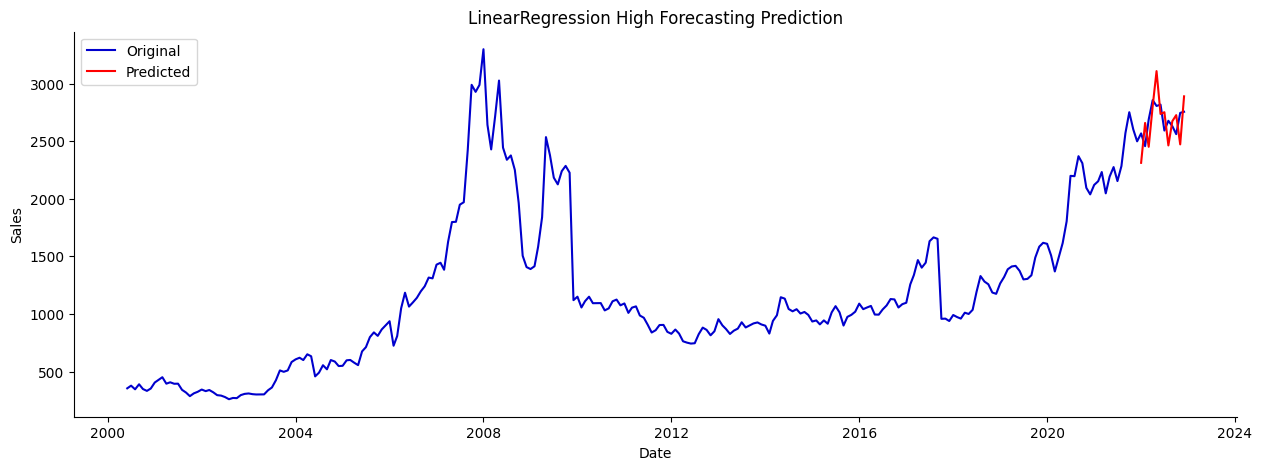

In [176]:
run_model(train, test, LinearRegression(), 'LinearRegression')

# Random Forest

<ipython-input-171-f17bfb2464e3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_df["Date "] = pd.to_datetime(original_df["Date "])


RMSE: 198.88358194347435
MAE: 184.63333333333335
R2 Score: -1.9162152538322381


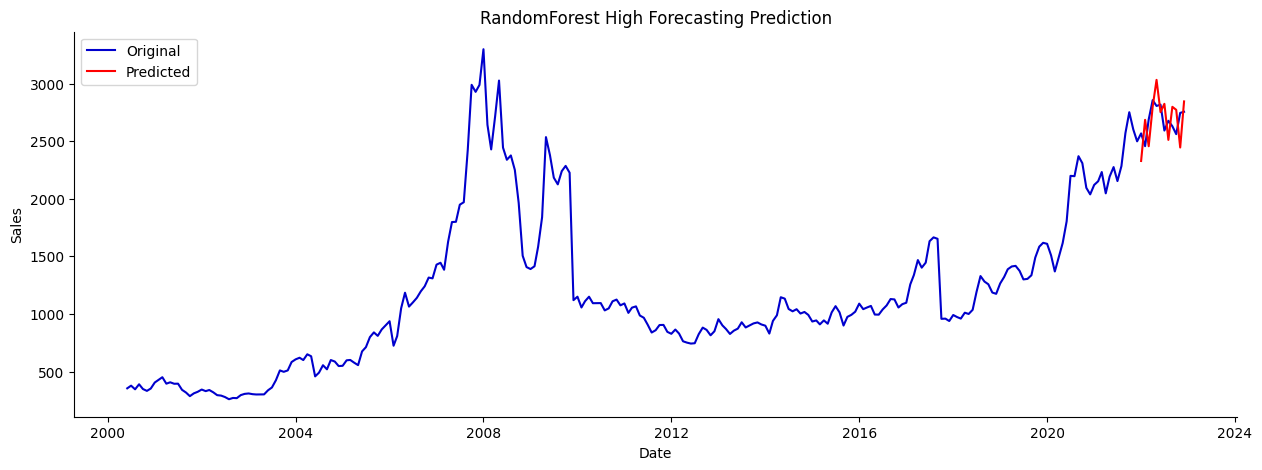

In [177]:
run_model(train, test, RandomForestRegressor(n_estimators=100, max_depth=20), 
          'RandomForest')

# XGBoost

<ipython-input-171-f17bfb2464e3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_df["Date "] = pd.to_datetime(original_df["Date "])


RMSE: 194.46628885233554
MAE: 178.4666666666667
R2 Score: -1.7881129504068443


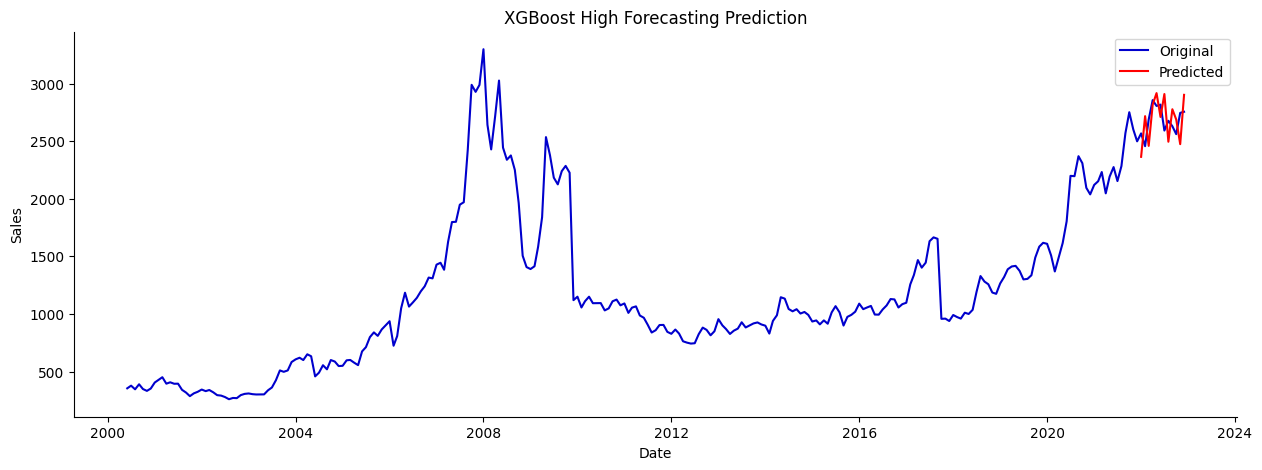

In [178]:
run_model(train, test, XGBRegressor( n_estimators=100, learning_rate=0.2, objective='reg:squarederror'), 'XGBoost')

# LSTM

In [179]:
def lstm_model(train_data, test_data):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
   
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), 
                   stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, 
              shuffle=False)
    predictions = model.predict(X_test,batch_size=1)
    
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object, lstm=True)
    unscaled_df = predict_df(unscaled, original_df)
    
    get_scores(unscaled_df, original_df, 'LSTM')
    
    plot_results(unscaled_df, original_df, 'LSTM')

Epoch 1/200
259/259 [==============================] - 4s 3ms/step - loss: 0.0448
Epoch 2/200
259/259 [==============================] - 1s 3ms/step - loss: 0.0421
Epoch 3/200
259/259 [==============================] - 1s 3ms/step - loss: 0.0400
Epoch 4/200
259/259 [==============================] - 1s 3ms/step - loss: 0.0380
Epoch 5/200
259/259 [==============================] - 1s 4ms/step - loss: 0.0361
Epoch 6/200
259/259 [==============================] - 1s 4ms/step - loss: 0.0342
Epoch 7/200
259/259 [==============================] - 1s 4ms/step - loss: 0.0325
Epoch 8/200
259/259 [==============================] - 1s 3ms/step - loss: 0.0310
Epoch 9/200
259/259 [==============================] - 1s 3ms/step - loss: 0.0298
Epoch 10/200
259/259 [==============================] - 1s 3ms/step - loss: 0.0288
Epoch 11/200
259/259 [==============================] - 1s 3ms/step - loss: 0.0280
Epoch 12/200
259/259 [==============================] - 1s 3ms/step - loss: 0.0274
Epoch 13/200


<ipython-input-171-f17bfb2464e3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_df["Date "] = pd.to_datetime(original_df["Date "])


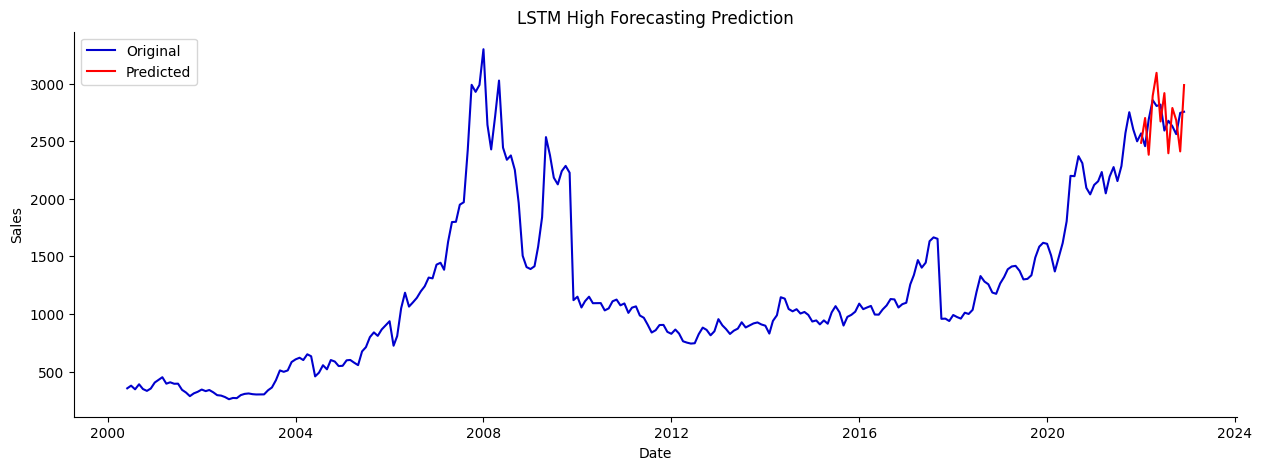

In [180]:
lstm_model(train, test)

In [181]:
model_scores

{'LinearRegression': [194.89365690037224,
  176.63333333333335,
  -1.8003809861604148],
 'RandomForest': [198.88358194347435, 184.63333333333335, -1.9162152538322381],
 'XGBoost': [194.46628885233554, 178.4666666666667, -1.7881129504068443],
 'LSTM': [233.79479071755782, 212.85833333333335, -3.029873109417003]}

In [182]:
result_df=pd.DataFrame(model_scores,index=["RMSE","MAE","R2"])

<Axes: >

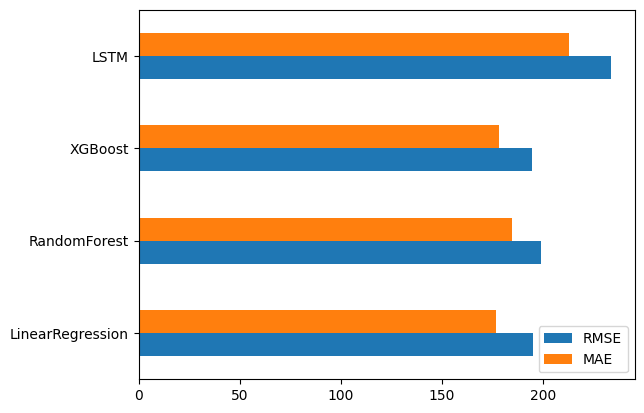

In [183]:
result_df[:2].T.plot(kind="barh")

# Holts Methods

In [184]:
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.holtwinters import SimpleExpSmoothing # Single Exponential Smoothing
from statsmodels.tsa.holtwinters import Holt # Holts (Double) Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing #Holt Winter's (Triple) Exponential Smoothing 

In [185]:
train=data[:-12]
test=data[-12:]

**Time series decomposition plot**

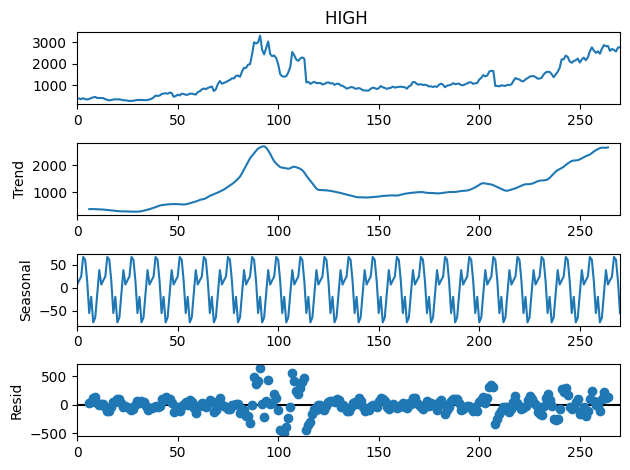

In [186]:
decompose_ts_add = seasonal_decompose(data["HIGH "], period = 12)
decompose_ts_add.plot()
plt.show()

# Simple Exponenial Smoothing

In [187]:
ses_model = SimpleExpSmoothing(train["HIGH "]).fit(smoothing_level = 0.9) # alpha = 0.9
pred_ses = ses_model.predict(start = test.index[0], end = test.index[-1])
rmse = np.sqrt(mean_squared_error(test["HIGH "], pred_ses))
mae= mean_absolute_error(test["HIGH "], pred_ses)
print(rmse)
print(mae)
ses={"Model":"SimpleExpo","rmse":rmse,"mae":mae}

205.30452008699854
178.0330543678201


# Holts Methos

In [188]:
hw_model = Holt(train["HIGH "]).fit(smoothing_level = 0.8, smoothing_slope = 0.2)
pred_hw = hw_model.predict(start = test.index[0], end = test.index[-1])
rmse = np.sqrt(mean_squared_error(test["HIGH "], pred_hw))
mae= mean_absolute_error(test["HIGH "], pred_hw)
print(rmse)
print(mae)
hw={"Model":"Holt Method","rmse":rmse,"mae":mae}

143.9069084281602
128.91615780336693


<ipython-input-188-dc88596b0320>:1: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  hw_model = Holt(train["HIGH "]).fit(smoothing_level = 0.8, smoothing_slope = 0.2)


# Holts winter exponential smoothing with additive seasonality and additive trend

In [189]:
hwe_model_add_add = ExponentialSmoothing(train["HIGH "], seasonal="add", trend="add", seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = test.index[0], end = test.index[-1])
rmse = np.sqrt(mean_squared_error(test["HIGH "], pred_hwe_add_add))
mae= mean_absolute_error(test["HIGH "], pred_hwe_add_add)
print(rmse)
print(mae)
hw_as_at={"Model":"Holts winter add seas&trend","rmse":rmse,"mae":mae}

126.05948717724354
101.00228072227576


# Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [190]:
hwe_model_mul_add = ExponentialSmoothing(train["HIGH "], seasonal="mul", trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test.index[0], end = test.index[-1])
rmse = np.sqrt(mean_squared_error(test["HIGH "], pred_hwe_mul_add))
mae= mean_absolute_error(test["HIGH "], pred_hwe_mul_add)
print(rmse)
print(mae)
hw_ms_at={"Model":"Holts winter add seas & mult trend","rmse":rmse,"mae":mae}

184.2791033105611
145.3031263220746


In [191]:
merge={**ses,**hw,**hw_as_at,**hw_ms_at}

In [192]:
merge

{'Model': 'Holts winter add seas & mult trend',
 'rmse': 184.2791033105611,
 'mae': 145.3031263220746}

In [193]:
df=pd.DataFrame({"Model":[ses["Model"],hw["Model"],hw_as_at["Model"],hw_ms_at["Model"]],"RMSE":[ses["rmse"],hw["rmse"],hw_as_at["rmse"],hw_ms_at["rmse"]],
                                                                                                "MSE":[ses["mae"],hw["mae"],hw_as_at["mae"],hw_ms_at["mae"]]},index=[ses["Model"],hw["Model"],hw_as_at["Model"],hw_ms_at["Model"]])

In [194]:
df

,Model,RMSE,MSE
SimpleExpo,SimpleExpo,205.304520,178.033054
Holt Method,Holt Method,143.906908,128.916158
Holts winter add seas&trend,Holts winter add seas&trend,126.059487,101.002281
Holts winter add seas & mult trend,Holts winter add seas & mult trend,184.279103,145.303126


<Axes: >

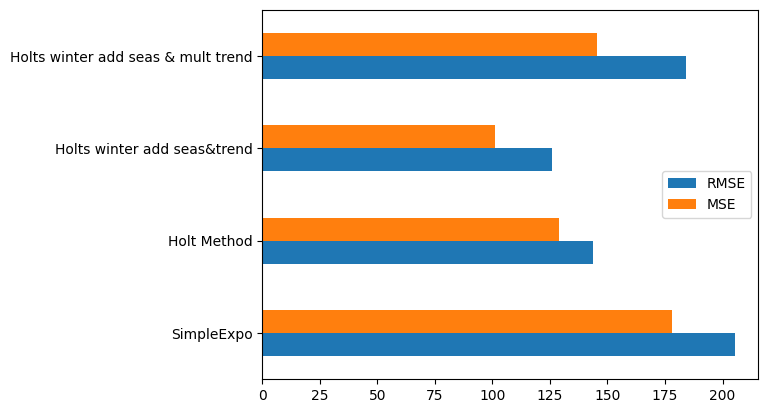

In [195]:
df.plot(kind="barh")

In [196]:
final_result=pd.DataFrame({"Model":['ARIMA','SARIMAx','LinearReg','XGBoost',hw["Model"],hw_as_at["Model"],],
                           "RMSE":[208.86,2.6254850544756925e-13,194.89,194.46,hw["rmse"],hw_as_at["rmse"],],
                           "MSE":[181.94,1.5158245029548803e-13,176.63,178.46,hw["mae"],hw_as_at["mae"],]},
                          index=['ARIMA','SARIMAx','LinearReg','XGBoost',hw["Model"],hw_as_at["Model"],])

<Axes: >

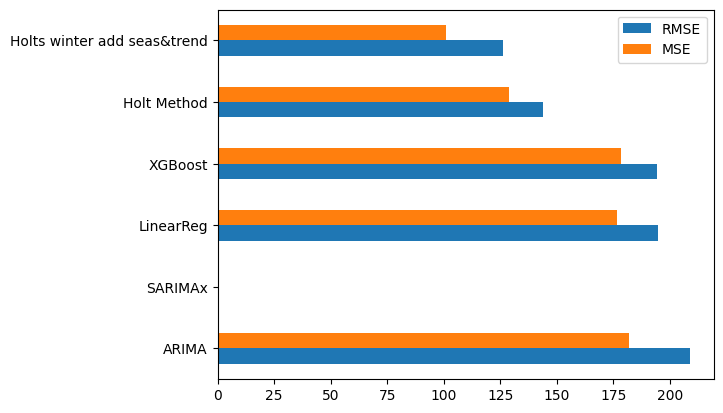

In [197]:
final_result.plot(kind="barh")